# 영화 리뷰 : 이진분류예제

* 리뷰 텍스트를 기반으로 영화 리뷰를 긍정과 부정으로 분류하는 예제
* IMDB 데이터 셋 사용

# 1. 데이터셋 로드

In [2]:
from keras.datasets import imdb
import warnings
warnings.filterwarnings('ignore')
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000) # 가장 자주 나타나는 단어 1만개만 사용하겠다 

# num_words = 10000 : 훈련데이터에서 가장 자주 나타나는 단어 10,000개만 사용하겠다는 의미
# 드물게 나타나는 단어는 무시
# 이렇게 하면 적절한 크기의 벡터 데이터를 얻을 수 있기 때문

* train_data / test_data : 리뷰 목록
    * 각 리뷰는 단어 인덱스의 리스트
    * 단어 시퀀스가 인코딩 된 것
* train_lables / test_labels : 레이블값
    * 0 : 부정
    * 1 : 긍정

In [3]:
print(train_data.shape)
print(test_data.shape)

(25000,)
(25000,)


In [4]:
train_labels[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [5]:
test_labels[:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [6]:
# num_words = 10000개로 제한
# 가장 자주 등장하는 단어 10000개로 제한했기 때문에 
# 단어 index는 10000을 넘지 않음
max([max(sequence) for sequence in train_data])

9999

# 2. 데이터 준비

* 현재 받아온 데이터는 list
* 신경망에 list는 쓸 수 없음
* 리스트를 텐서로 바꿔줘야 함 --> 원-핫 인코딩 방법을 사용하여 변환하는 게 편함
* 방법 
1. 같은 길이가 되도록 리스트에 패딩 추가하고 (samples,sequence_length)크기의 정수 텐서로 변환
2. 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환

In [7]:
import numpy as np

def vectorize_sequences(sequences,dimension=10000):
    results=np.zeros((len(sequences),dimension)) # 크기가 (len(sequences),dimensions)이고 모든 원소가 0인 행렬을 만듦 (25000,10000)
    for i,sequence in enumerate(sequences):
        results[i,sequence]=1. # results[i]에서 특정 위치를 1로 만듦
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [10]:
x_test

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [11]:
# 레이블은 쉽게 벡터로 변경 가능
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 3. 신경망 모델 만들기
* 입력 데이터가 벡터
* 레이블은 스칼라 (0 또는 1)
    * 이런 문제에 잘 작동하는 네트워크 종류는 'relu'활성화 함수를 사용한 완전한 연결 층
* Dense층에 전달한 매개변수(16)은 은닉 유닛의 개수
    * 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 됨
* 16개의 은닉 유닛이 있다는 것은 가중치 행렬의 크기가 16이라는 뜻
* 그리고 편향 벡터 'b'를 더하고 'relu'연산을 적용 

* 은닉 유닛을 늘리면 (표현 공간을 더 고차원으로 만들면)
* 신경망이 더 복잡한 표현을 학습할 수 있지만
* 계산 비용이 커지고 원치않는 패턴을 학습할 수도 있음

* Dense층을 쌓을 때 두가지 중요한 구조상의 결정이 필요
* 얼마나 많은 층을 사용할 것인가?
* 각 층에 얼마나 많은 은닉 유닛을 둘 것인가

## 신경망 모델 만드는 작업 순서
1. 모델 설정
2. 모델 컴파일
3. 모델 실행 (학습)
4. 모델 평가 (결과 출력)

In [26]:
from keras import models
from keras import layers
import tensorflow as tf

tf.random.set_seed(3)

# 1. 모델 설정
model = models.Sequential()
model.add(layers.Dense(16,activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
# 중간의 은닉층은 활성화 함수로 'relu'사용
# 음수는 0으로 만듦 
model.add(layers.Dense(1,activation='sigmoid'))


# 마지막 층은 확률을 출력하기 위해 시그모이드 활성화 함수 사용
# 0-1사이의 점수로 어떤 샘플이 1일 가능성이 높다는 것은 글 리뷰가 긍정일 가능성이 높다는 것 

# 2. 모델 컴파일
# 손실 함수와 옵티마이저 선택
# 손실 함수 : 이진분류 문제이고 신경망의 출력이 확률이기 때문에 (네트워크 끝에 시그모이드 함수를 사용한 하나의 유닛으로 된 층으로 놓았음) : binary_crossentropy
# 옵티마이저 : optimizer = 'rmsprop', 옵티마이저 매개변수 변경시 : optimizer=optimizers.RMSprop(lr=0.001)
model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])




# 4. 훈련 검증 데이터 셋 생성
* 검증 데이터 셋 생성
    * 훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해 원본 훈련 데이터에서 10,000개의 샘플을 따로 분리해서 검증 데이터 셋으로 생성

In [27]:
x_val = x_train[:10000] # 10,000개까지
partial_x_train = x_train[10000:] # 10,000개부터 끝까지 

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [28]:
# 3. 모델 실행 (학습)
# 모델을 512개 샘플씩 미니 배치를 만들어 20번 에포크 동안 훈련
# x_train과 y_train 텐서에 있는 모든 샘플에 대해 20번 반복
# partial_x_train, partial_y_train 손실과 정확도도 측정
# validation_data 매개변수

model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val,y_val))

# 정리
# history에는 loss, acc, val_loss, val_acc가 저장되어있음
# 훈련 손실, 훈련 정확도, 검증 손실, 검증 정확도

Epoch 1/20
30/30 [==============================] - 10s 226ms/step - loss: 0.5805 - acc: 0.7119 - val_loss: 0.3853 - val_acc: 0.8607
Epoch 2/20
30/30 [==============================] - 2s 74ms/step - loss: 0.3192 - acc: 0.9042 - val_loss: 0.3229 - val_acc: 0.8758
Epoch 3/20
30/30 [==============================] - 2s 61ms/step - loss: 0.2270 - acc: 0.9282 - val_loss: 0.3136 - val_acc: 0.8709
Epoch 4/20
30/30 [==============================] - 2s 71ms/step - loss: 0.1777 - acc: 0.9458 - val_loss: 0.2813 - val_acc: 0.8867
Epoch 5/20
30/30 [==============================] - 2s 77ms/step - loss: 0.1405 - acc: 0.9567 - val_loss: 0.2816 - val_acc: 0.8856
Epoch 6/20
30/30 [==============================] - 2s 61ms/step - loss: 0.1165 - acc: 0.9674 - val_loss: 0.2946 - val_acc: 0.8843
Epoch 7/20
30/30 [==============================] - 2s 75ms/step - loss: 0.0964 - acc: 0.9718 - val_loss: 0.3084 - val_acc: 0.8823
Epoch 8/20
30/30 [==============================] - 2s 65ms/step - loss: 0.0820 -

# 5.matplotlib을 사용해 훈련과 검증 데이터에 대한 손실과 정확도를 시각화
* model.fit( ) 메서드 반환하는 history객체 생성
* 이 객체는 훈련하는 동안에 발생한 모든 정보를 딕셔너리 형태로 가지고 있음 

In [34]:
history_dict = history.history
print(history_dict.keys()) # 훈련과 검증하는 동안 모니터링할 측정 지표 
print(history_dict.items()) # 훈련과 검증하는 동안 측정지표값 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
dict_items([('loss', [0.5035755634307861, 0.3022335171699524, 0.22488442063331604, 0.17656077444553375, 0.14671792089939117, 0.11833220720291138, 0.09818793088197708, 0.08410487323999405, 0.0688680037856102, 0.05868445709347725, 0.047817375510931015, 0.038566865026950836, 0.03124043345451355, 0.025929998606443405, 0.022831663489341736, 0.01399650052189827, 0.014274179004132748, 0.010821590200066566, 0.008748706430196762, 0.009948132559657097]), ('acc', [0.7921333312988281, 0.9043333530426025, 0.9262666702270508, 0.944266676902771, 0.9520666599273682, 0.9644666910171509, 0.9700666666030884, 0.9760666489601135, 0.9814666509628296, 0.9854666590690613, 0.98826664686203, 0.9918000102043152, 0.9932666420936584, 0.9951333403587341, 0.9955333471298218, 0.9991999864578247, 0.998199999332428, 0.9989333152770996, 0.9990666508674622, 0.9980000257492065]), ('val_loss', [0.38531821966171265, 0.3228786587715149, 0.3136233985424042, 0.2812817692756653,

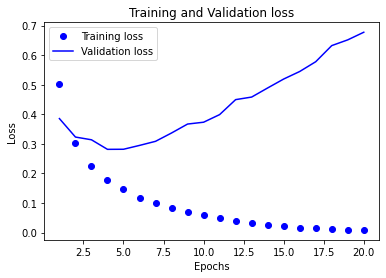

In [35]:
# 훈련과 검증 손실 시각화
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(loss)+1) # epochs 1부터 마지막까지 (n+1)

plt.plot(epochs, loss, 'bo',label = 'Training loss')
plt.plot(epochs, val_loss, 'b',label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 너무 과적합하게 훈련해서 오류 발생? 

### 훈련 손실 결과
* 에포크가 증가할수록 훈련 손실 감소
* 경사하강법 최적화를 사용했을 때 반복마다 최소화되는 것이 손실
* 그러므로 반복할때마다 손실이 최소화 (기대했던대로)


### 검증 손실 결과
* 그런데 검증 손실 결과는 네번째 에포크에서 그래프가 역전되는 것처럼 보임
* 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에서는 잘 작동되지 않음 ==> **과대적합(overfitting)** 
* 두번째 에포크부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외의 데이터에는 일반화되지 못함
* 이런 경우 과대적합 방지를 위해
* 3번째 에포크 이후에 훈련을 중지할 수 있음

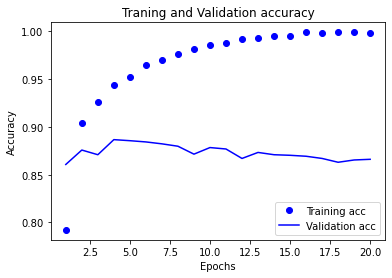

In [36]:
# 훈련과 검증 정확도 시각화
plt.clf() # 그래프 초기화 
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Traning and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 처음부터 다시 새로운 신경망을 만들어서 4번의 에포크동안만 훈련하고 테스트 데이터에서 평가

In [40]:
# 처음부터 다시 새로운 신경망을 만들어서 4번의 에포크동안만 훈련하고 테스트 데이터에서 평가

tf.random.set_seed(3)


model = models.Sequential()
model.add(layers.Dense(16,activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))

model.add(layers.Dense(1,activation='sigmoid'))


model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=4,
                   batch_size=512,
                   validation_data=(x_val,y_val))

results = model.evaluate(x_val,y_val)



Epoch 1/4
30/30 [==============================] - 6s 118ms/step - loss: 0.5805 - acc: 0.7119 - val_loss: 0.3853 - val_acc: 0.8607
Epoch 2/4
30/30 [==============================] - 2s 59ms/step - loss: 0.3192 - acc: 0.9042 - val_loss: 0.3229 - val_acc: 0.8758
Epoch 3/4
30/30 [==============================] - 2s 63ms/step - loss: 0.2270 - acc: 0.9282 - val_loss: 0.3136 - val_acc: 0.8709
Epoch 4/4
313/313 [==============================] - 3s 9ms/step - loss: 0.2813 - acc: 0.8867


In [41]:
results

[0.2812816798686981, 0.8866999745368958]

### 4번 에포크 동안의 결과
Epoch 20/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.6774 - val_acc: 0.8661  
Epoch 4/4
30/30 [==============================] - 1s 35ms/step - loss: 0.1777 - acc: 0.9458 - val_loss: 0.2813 - val_acc: 0.8867

* 과대적합이 6번 에포크부터 발생했다는 확인하에
* 4번, 5번 에포크 동안 훈련한 결과
* 4번 에포크 수행시 검증 손실이 많이 줄었음 (val_loss : 0.6774 -> 0.2813)

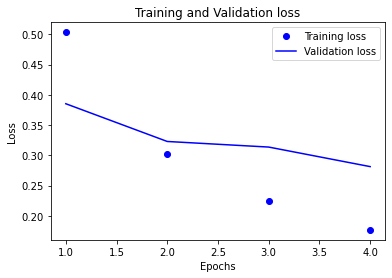

In [42]:
# 다시 시각화
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(loss)+1) # epochs 1부터 마지막까지 (n+1)

plt.plot(epochs, loss, 'bo',label = 'Training loss')
plt.plot(epochs, val_loss, 'b',label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

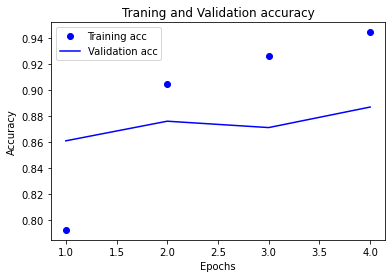

In [43]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Traning and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 모델을 처음부터 다시 훈련하기

In [13]:
from keras import models
from keras import layers
import tensorflow as tf
tf.random.set_seed(3)


model = models.Sequential()
model.add(layers.Dense(16,activation='relu', input_shape=(10000,)))
# Dense(unit은 거의 2의 배수로 씀. e.g. 16, 32, 64 이렇게 )
model.add(layers.Dense(16,activation='relu'))

model.add(layers.Dense(1,activation='sigmoid'))


model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

model.fit(x_train,
                   y_train,
                   epochs=4,
                   batch_size=512)

results = model.evaluate(x_test,y_test)

Epoch 1/4
49/49 [==============================] - 2s 22ms/step - loss: 0.5458 - acc: 0.7474
Epoch 2/4
49/49 [==============================] - 1s 23ms/step - loss: 0.2772 - acc: 0.9074
Epoch 3/4
49/49 [==============================] - 1s 22ms/step - loss: 0.1998 - acc: 0.9305
Epoch 4/4
782/782 [==============================] - 13s 17ms/step - loss: 0.2911 - acc: 0.8853


In [14]:
results

[0.2910781800746918, 0.8852800130844116]

In [15]:
model.predict(x_test)

array([[0.18875423],
       [0.99983513],
       [0.93763626],
       ...,
       [0.13299632],
       [0.06220827],
       [0.6779878 ]], dtype=float32)

* 우리가 생성한 모델은 어떤 샘플에 대해 확신을 가지고 있고 (0.99이상, 0.01이하인 경우) 
* 어떤 샘플에 대해서는 확신이 부족 (0.6, 0.4)

# 결과 정리
* 원본 데이터를 신경망에 텐서로 주입하기 위해서는 많은 전처리 작업이 필요하다
* 단어 시퀀스는 이진벡터로 인코딩 
* relu 활성화 함수와 함께 Dense층을 쌓은 네트워크(모델)는 감성 분류 등 여러 종류의 문제에 적용할 수 있어서 앞으로 자주 사용함
* 출력 클래스가 2개인 이진 분류 문제에는 하나의 유닛과 sigmoid 활성화 함수를 가진 Dense층으로 끝나야 함
* 신경망의 출력은 확률을 나타내는 0과 1사이의 스칼라 값
* 이진분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용하는 손실 함수는 : binary_crossentropy
* rmsprop 옵티마이저는 관계없이 사용가능
* 훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 과대적합되기 시작
* 이전에 본적 없는 테스트 데이터에서는 결과가 점점 나빠짐